In [27]:
import sys
sys.path.insert(1, '../../Src')
from utils.preprocessing import *
import training

import numpy as np
import pandas as pd
import os

import glob
from math import ceil
from sklearn.metrics import mean_squared_error


warnings.filterwarnings('ignore')

PATH_DATASET = '../../dataset/'
PATH_RESULTS = '../../results/Demanda_ventana3_no_enc/'


FILL = False
TARGET = 'Demanda'


N_FOLDS = 3
N_FEATURE_IMPORTANCE = 15

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
SEED = 42
seed_everything(SEED)
training.PATH_RESULTS = PATH_RESULTS
training.submission_analysis.TARGET  = TARGET

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
submission_top_reference = 'submission_weeks2_repz12_rmse_kaggle_0.686.csv'
print('reading .. ',os.path.join('../../results/',submission_top_reference))
result = pd.read_csv(os.path.join('../../results/',submission_top_reference))

reading ..  ../../results/submission_weeks2_repz12_rmse_kaggle_0.686.csv


In [29]:
result.head()

,ID,Demanda
0,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.010752
1,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.015741
2,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.000000
3,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.000000
4,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.000000


In [30]:
descriptive_columns = ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK']
reverse_mapping_file = '../../utils/reverse_dict_mapping_list.txt'

result[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK']] = result['ID'].str.split('|',expand=True)

with open(reverse_mapping_file, 'rb') as f:
    reverse_mapping = pickle.load( f)
    
descriptive_columns = ['Z_MARCA', 'Z_GAMA', 'Z_MODELO',
                       'Z_DEPARTAMENTO', 'Z_PUNTO_VENTA']
i=0
for column in descriptive_columns:
    if column in ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK']:
        inv_reverse_mapping = {v: k for k, v in reverse_mapping[i].items()}

        result[column] = result[column].map(inv_reverse_mapping)
    i+=1
    
result = result.rename(columns = {TARGET: TARGET+'_real'})

In [31]:
result.head()

,ID,Demanda_real,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,Z_WEEK
0,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.010752,MOD_170,PVENT_259,GAM_2,SEMANA_51
1,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.015741,MOD_170,PVENT_259,GAM_2,SEMANA_52
2,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.000000,MOD_170,PVENT_259,GAM_2,SEMANA_53
3,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.000000,MOD_170,PVENT_259,GAM_2,SEMANA_54
4,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.000000,MOD_170,PVENT_259,GAM_2,SEMANA_55


In [44]:
result['Demanda_pred'] = 0

WEEKS_LIST = {}

TOTAL_FILES = 0
for week in range(1,11):
    for idx,model_type in enumerate(['xgboost']):
        for model in ['c_model_v3','c_model_v2']:
            path_folder = os.path.join(PATH_RESULTS,model_type,model,'shift_'+str(week))
            list_filename_csv = glob.glob(os.path.join(path_folder,"*_submission.csv"))
            if len(list_filename_csv)>0:
                score = float(list_filename_csv[0].split('rmse_cv_test_')[-1].split('_')[0])
                
                if score>(2.15+week*50):#*0.15):
                    break
                print('reading ..',list_filename_csv[0])
                TOTAL_FILES+=1
                filename_csv = list_filename_csv[0]
                pred = pd.read_csv(filename_csv).rename(columns={"Demanda":"Demanda_pred"}).reset_index(drop=True)
                SEMANA = 'SEMANA_'+str(50+week)
                
                if SEMANA in WEEKS_LIST.keys():
                    WEEKS_LIST[SEMANA]+=1.0
                else:
                    WEEKS_LIST[SEMANA]=1.0
                
                sub_group = result[["Z_MODELO","Z_PUNTO_VENTA","Z_GAMA","Z_WEEK"]][result['Z_WEEK']==SEMANA].merge(
                    pred[["Z_MODELO","Z_PUNTO_VENTA","Z_GAMA","Z_WEEK","Demanda_pred"]],how='left').reset_index(drop=True)
                
                result['Demanda_pred'][result['Z_WEEK']==SEMANA] += sub_group['Demanda_pred'].values
print('TOTAL_FILES = ',TOTAL_FILES)

reading .. ../../results/Demanda_ventana3_no_enc/xgboost/c_model_v3/shift_1/rmse_cv_train_2.8387_rmse_cv_test_2.2255_submission.csv
reading .. ../../results/Demanda_ventana3_no_enc/xgboost/c_model_v2/shift_1/rmse_cv_train_2.7379_rmse_cv_test_2.7874_submission.csv
reading .. ../../results/Demanda_ventana3_no_enc/xgboost/c_model_v3/shift_2/rmse_cv_train_3.2605_rmse_cv_test_2.6418_submission.csv
reading .. ../../results/Demanda_ventana3_no_enc/xgboost/c_model_v2/shift_2/rmse_cv_train_3.157_rmse_cv_test_3.4779_submission.csv
reading .. ../../results/Demanda_ventana3_no_enc/xgboost/c_model_v3/shift_3/rmse_cv_train_3.6463_rmse_cv_test_3.4624_submission.csv
reading .. ../../results/Demanda_ventana3_no_enc/xgboost/c_model_v2/shift_3/rmse_cv_train_3.5182_rmse_cv_test_3.9477_submission.csv
reading .. ../../results/Demanda_ventana3_no_enc/xgboost/c_model_v3/shift_4/rmse_cv_train_3.836_rmse_cv_test_3.6341_submission.csv
reading .. ../../results/Demanda_ventana3_no_enc/xgboost/c_model_v2/shift_4/rm

In [45]:
for SEMANA in WEEKS_LIST:
    result['Demanda_pred'][result['Z_WEEK']==SEMANA] /= WEEKS_LIST[SEMANA]

In [46]:
SEMANA

'SEMANA_58'

In [47]:
result.head()

,ID,Demanda_real,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,Z_WEEK,Demanda_pred
0,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.010752,MOD_170,PVENT_259,GAM_2,SEMANA_51,0.043888
1,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.015741,MOD_170,PVENT_259,GAM_2,SEMANA_52,0.070066
2,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.000000,MOD_170,PVENT_259,GAM_2,SEMANA_53,0.080724
3,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.000000,MOD_170,PVENT_259,GAM_2,SEMANA_54,0.100366
4,009e0874cc07b2180b2b2b1039321041a1f42e66693c49...,0.000000,MOD_170,PVENT_259,GAM_2,SEMANA_55,0.101997


In [48]:
result['Demanda_pred'][~result['Z_WEEK'].isin(WEEKS_LIST.keys())]  = result['Demanda_real'][~result['Z_WEEK'].isin(WEEKS_LIST.keys())] 

Saving analysis by week .. 


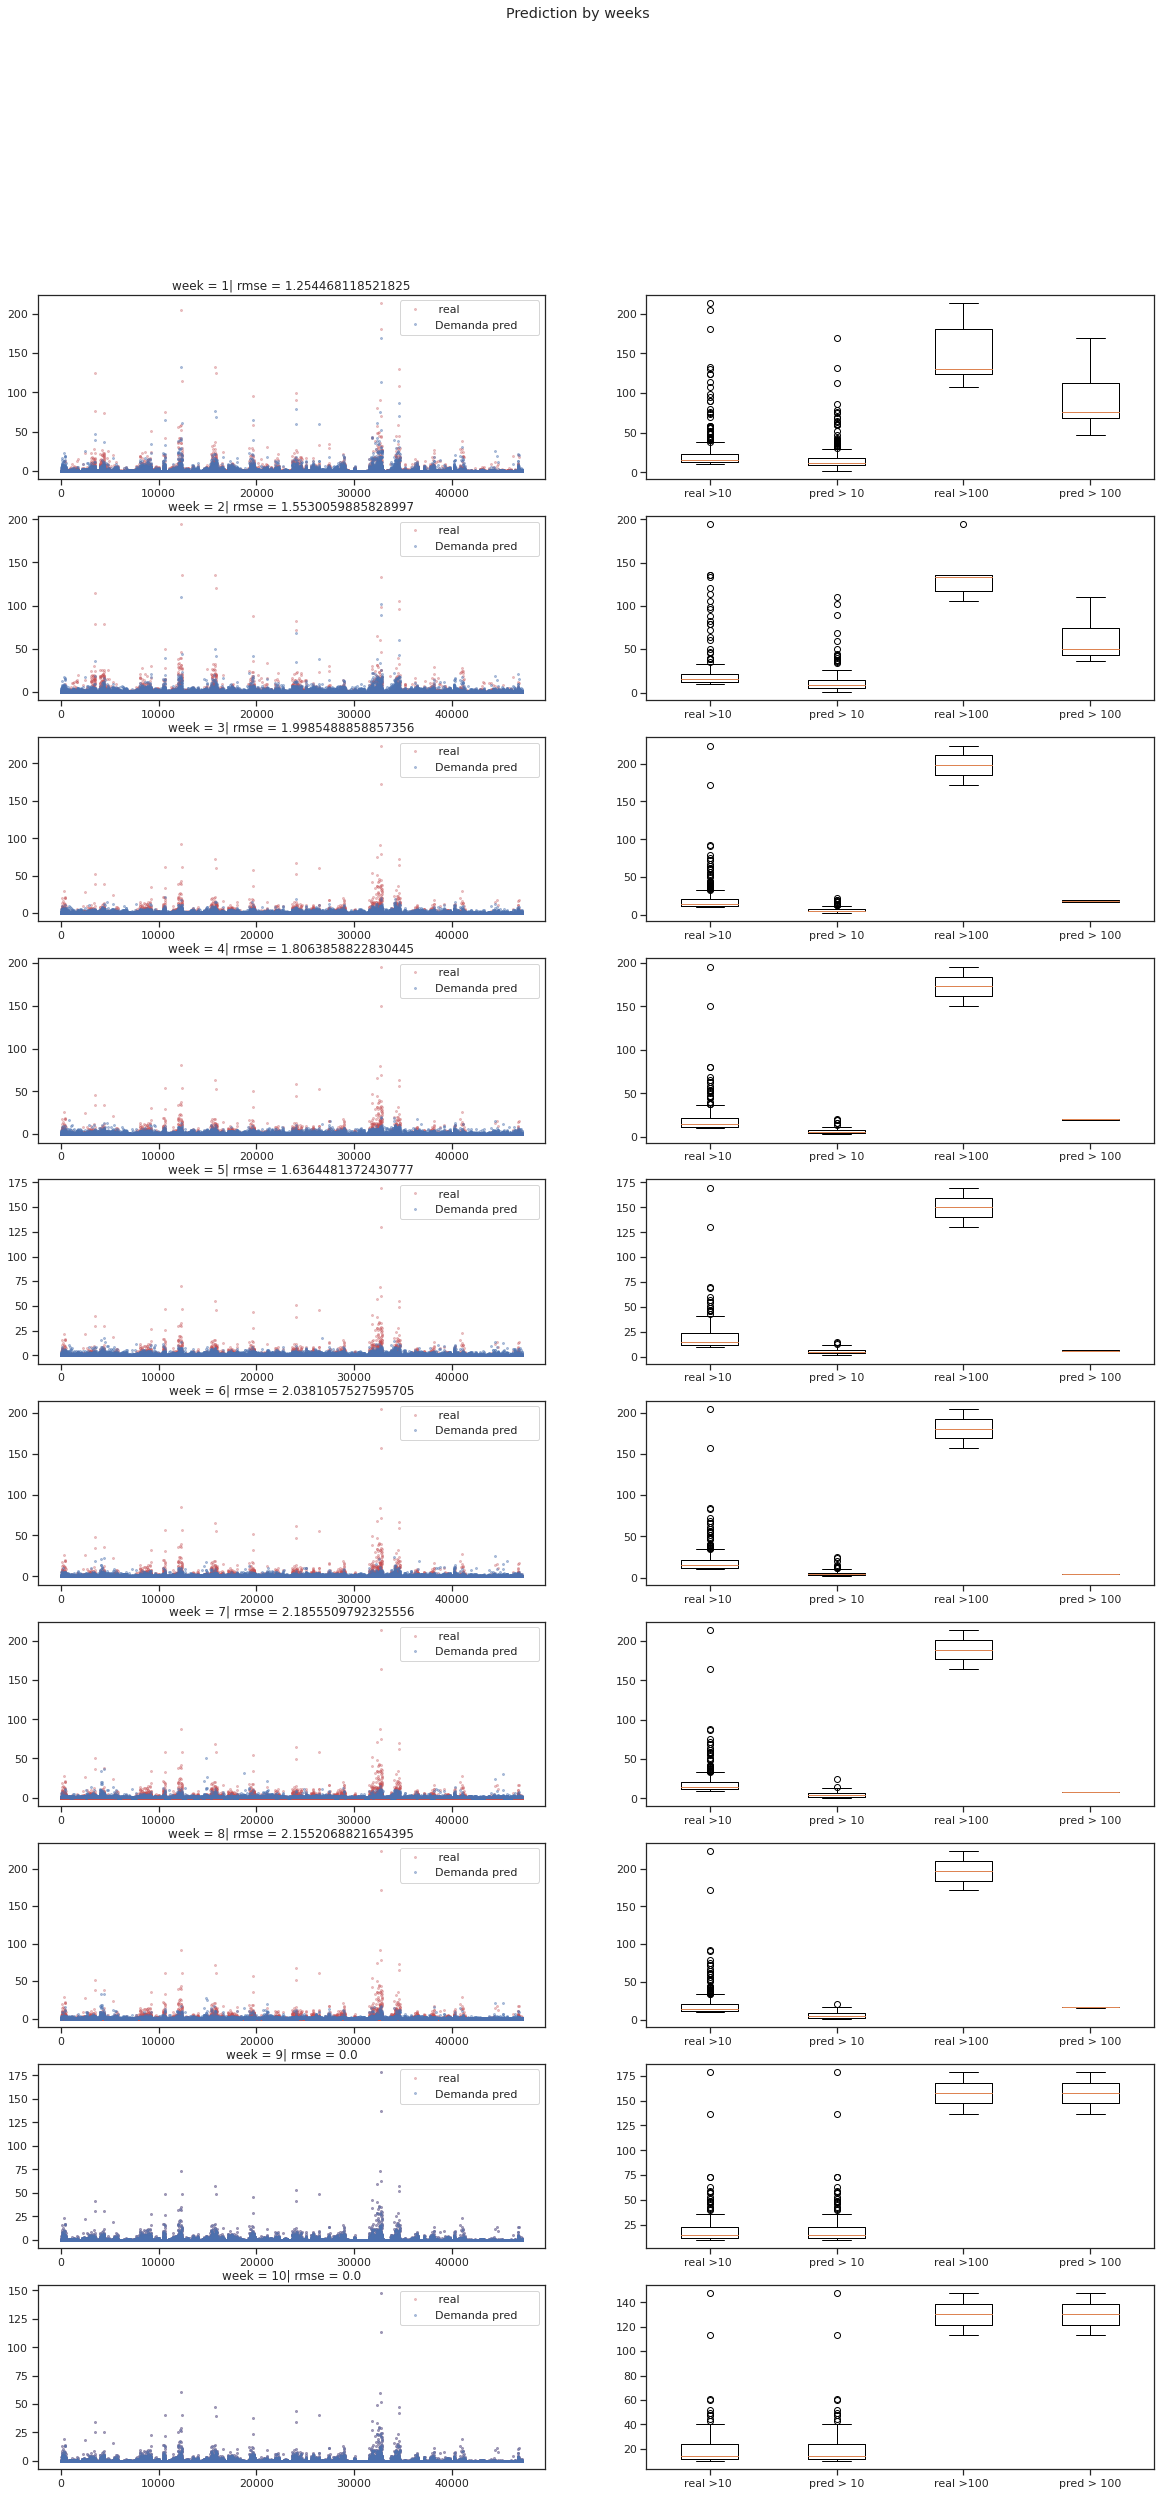

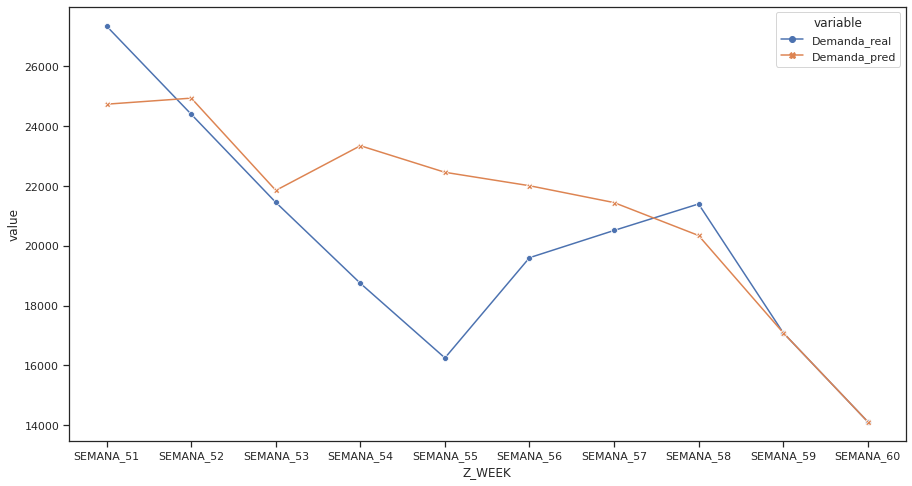

In [49]:

print('Saving analysis by week .. ')
mini = result['Z_WEEK'].min()
maxi = result['Z_WEEK'].max()
fig = plt.figure(figsize=(20,40))

for idx,i in enumerate(range(1,11)):
    plt.subplot(10,2,idx*2+1)
    sub_real = result[TARGET+'_real'][result['Z_WEEK']=='SEMANA_'+str(50+i)].values
    sub_pred = result[TARGET+'_pred'][result['Z_WEEK']=='SEMANA_'+str(50+i)].values
    
    plt.plot(range(len(sub_real)),sub_real,'ro', alpha=0.3, label= ' real',markersize=2)
    plt.plot(range(len(sub_pred)),sub_pred,'bo', alpha=0.4,label=TARGET+' pred     ',markersize=2)
    difference = mean_squared_error(sub_real,sub_pred, squared=False)
    plt.title('week = '+str(i)+'| rmse = '+str(difference))
    plt.legend( loc ="upper right")
    plt.subplot(10,2,idx*2+2)
    my_dict = {
        'real >10 ': sub_real[sub_real>10], 
        'pred > 10':sub_pred[sub_real>10],
        'real >100 ': sub_real[sub_real>100], 
        'pred > 100':sub_pred[sub_real>100]
    }

    plt.boxplot(my_dict.values())
    plt.xticks(range(1,len(my_dict.keys())+1),my_dict.keys())
plt.suptitle('Prediction by weeks')
#plt.savefig(path)
#plt.close()
plt.show()

total_semanal = result[['Z_WEEK','Demanda_real','Demanda_pred']].groupby(['Z_WEEK']).sum().reset_index()
total_semanal_melt = pd.melt(total_semanal, id_vars =['Z_WEEK'], value_vars =['Demanda_real', 'Demanda_pred'])
plt.figure(figsize=(15,8))
sns.lineplot(x="Z_WEEK", y="value", data=total_semanal_melt, hue="variable",style="variable",markers=True, dashes=False)
plt.show()

In [50]:
result['Demanda_pred'][result['Z_WEEK']=='SEMANA_51']  = 0.2*result['Demanda_pred'][result['Z_WEEK']=='SEMANA_51'] + 0.8*result['Demanda_real'][result['Z_WEEK']=='SEMANA_51']

In [51]:
result['Demanda_pred'][result['Z_WEEK']=='SEMANA_52']  = 0.2*result['Demanda_pred'][result['Z_WEEK']=='SEMANA_52'] + 0.8*result['Demanda_real'][result['Z_WEEK']=='SEMANA_52']

In [52]:
result['Demanda_pred'][result['Z_WEEK']=='SEMANA_53']  = 0.2*result['Demanda_pred'][result['Z_WEEK']=='SEMANA_53'] + 0.8*result['Demanda_real'][result['Z_WEEK']=='SEMANA_53']

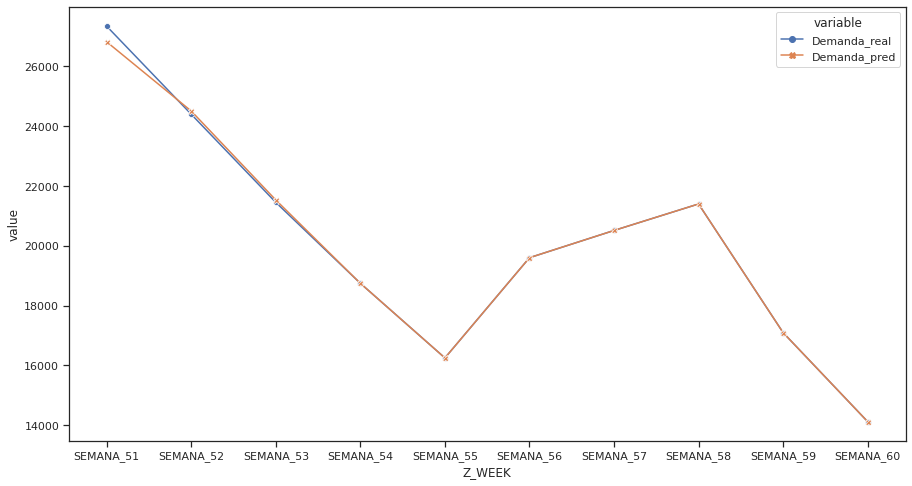

In [53]:
if True:
    casteo_semanas =['SEMANA_51','SEMANA_52','SEMANA_53']
    result['Demanda_pred'][~result['Z_WEEK'].isin(casteo_semanas)]  = result['Demanda_real'][~result['Z_WEEK'].isin(casteo_semanas)] 
    total_semanal = result[['Z_WEEK','Demanda_real','Demanda_pred']].groupby(['Z_WEEK']).sum().reset_index()
    total_semanal_melt = pd.melt(total_semanal, id_vars =['Z_WEEK'], value_vars =['Demanda_real', 'Demanda_pred'])
    plt.figure(figsize=(15,8))
    sns.lineplot(x="Z_WEEK", y="value", data=total_semanal_melt, hue="variable",style="variable",markers=True, dashes=False)
    plt.show()

In [54]:
rmse_target = mean_squared_error(result[TARGET+'_pred'],result[TARGET+'_real'], squared=False)

submissions_path = os.path.join(PATH_RESULTS,'submissions','submission_weeks123_no_enc_pred_0.2_pred_0.8_real_rmse_kaggle_'+str(np.round(rmse_target,3))+'.csv')
print('saving submission ..',submissions_path)

print('Final score referencial mean_squared_error')
print('RMSE Score referencial TARGET:',rmse_target)

if True:
    print('saving ..')
    result[['ID','Demanda_pred']].rename(columns={"Demanda_pred":"Demanda"}).to_csv(submissions_path,index=None)
    print('saved ! ')

saving submission .. ../../results/Demanda_ventana3_no_enc/submissions/submission_weeks123_no_enc_pred_0.2_pred_0.8_real_rmse_kaggle_0.179.csv
Final score referencial mean_squared_error
RMSE Score referencial TARGET: 0.17865850676905531
saving ..
saved ! 


In [20]:
# 0.411640722476265